In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
# Create data directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# Settings for better visualization
%matplotlib inline
sns.set_theme(style="whitegrid")

In [6]:
# Replace 'data/complaints.csv' with your actual path
file_path = '../data/raw/complaints.csv'

# We use low_memory=False to handle the large dataset efficiently
print("Loading data... this may take a minute.")
df = pd.read_csv(file_path, low_memory=False)

print(f"Dataset Loaded. Shape: {df.shape}")
df.head()

Loading data... this may take a minute.
Dataset Loaded. Shape: (9609797, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


Total Complaints: 9609797
Complaints WITH Narratives: 2980756 (31.02%)
Complaints WITHOUT Narratives: 6629041


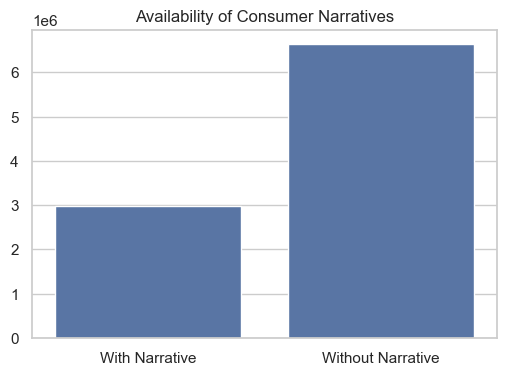

In [7]:
# Check for nulls in the narrative column
total_rows = len(df)
null_narratives = df['Consumer complaint narrative'].isnull().sum()
has_narrative = total_rows - null_narratives

print(f"Total Complaints: {total_rows}")
print(f"Complaints WITH Narratives: {has_narrative} ({(has_narrative/total_rows)*100:.2f}%)")
print(f"Complaints WITHOUT Narratives: {null_narratives}")

# Visualize the split
plt.figure(figsize=(6, 4))
sns.barplot(x=['With Narrative', 'Without Narrative'], y=[has_narrative, null_narratives])
plt.title('Availability of Consumer Narratives')
plt.show()

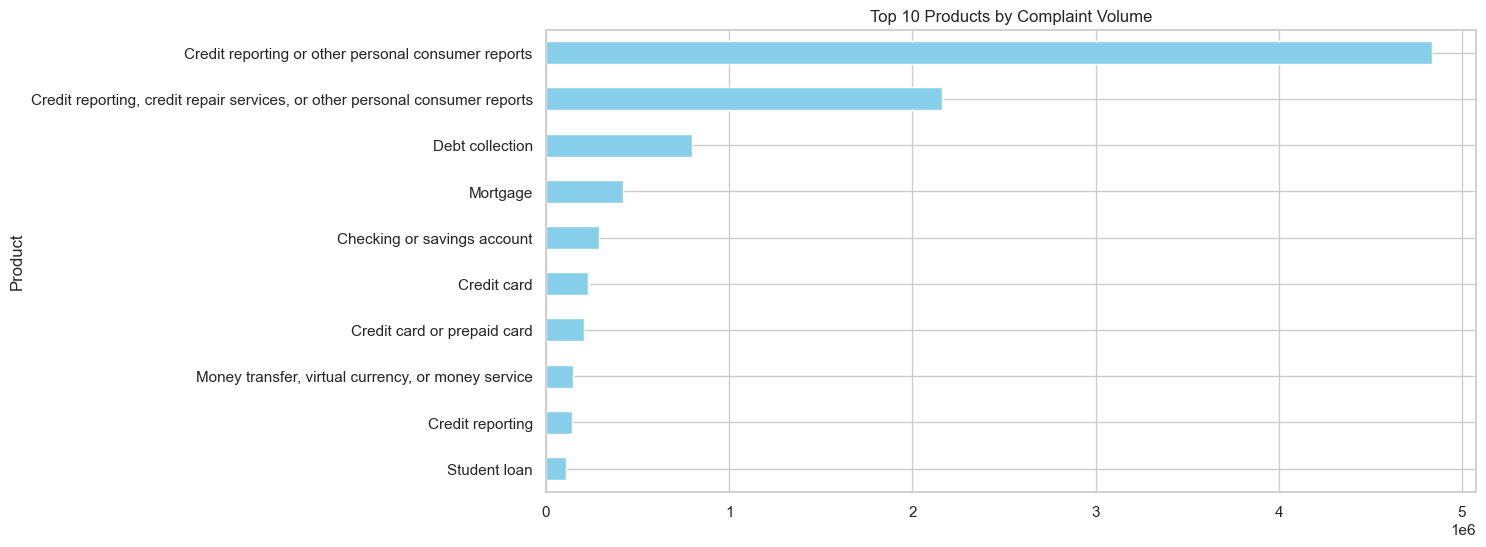

In [8]:
# Analyze the top products in the entire dataset
plt.figure(figsize=(12, 6))
df['Product'].value_counts().head(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Products by Complaint Volume')
plt.gca().invert_yaxis()
plt.show()

In [9]:
# Define target categories (adjust names based on exact dataset labels)
target_products = [
    'Credit card', 
    'Credit card or prepaid card',
    'Personal loan', 
    'Installment loan',
    'Savings account', 
    'Checking or savings account',
    'Money transfer, virtual currency, or money service'
]

# Filter
df_filtered = df[df['Product'].isin(target_products)].copy()

# Remove rows where narrative is missing
df_filtered = df_filtered.dropna(subset=['Consumer complaint narrative'])

print(f"Filtered Dataset Shape: {df_filtered.shape}")
print(f"Unique Products included: {df_filtered['Product'].unique()}")

Filtered Dataset Shape: (426841, 18)
Unique Products included: ['Credit card' 'Checking or savings account'
 'Money transfer, virtual currency, or money service'
 'Credit card or prepaid card']


In [10]:
def clean_narrative(text):
    if not isinstance(text, str):
        return ""
    
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove CFPB PII masks (e.g., XXXX, XX/XX/2022)
    text = re.sub(r'x+', '', text)
    text = re.sub(r'\d{2}/\d{2}/\d{4}', '', text)
    
    # 3. Remove boilerplate phrases
    boilerplate = [
        "i am writing to file a complaint",
        "to whom it may concern",
        "thank you",
        "dear cfpb"
    ]
    for phrase in boilerplate:
        text = text.replace(phrase, "")
        
    # 4. Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # 5. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning
print("Cleaning narratives... this may take a few minutes.")
df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_narrative)

# Calculate word counts for analysis
df_filtered['word_count'] = df_filtered['cleaned_narrative'].apply(lambda x: len(x.split()))

Cleaning narratives... this may take a few minutes.


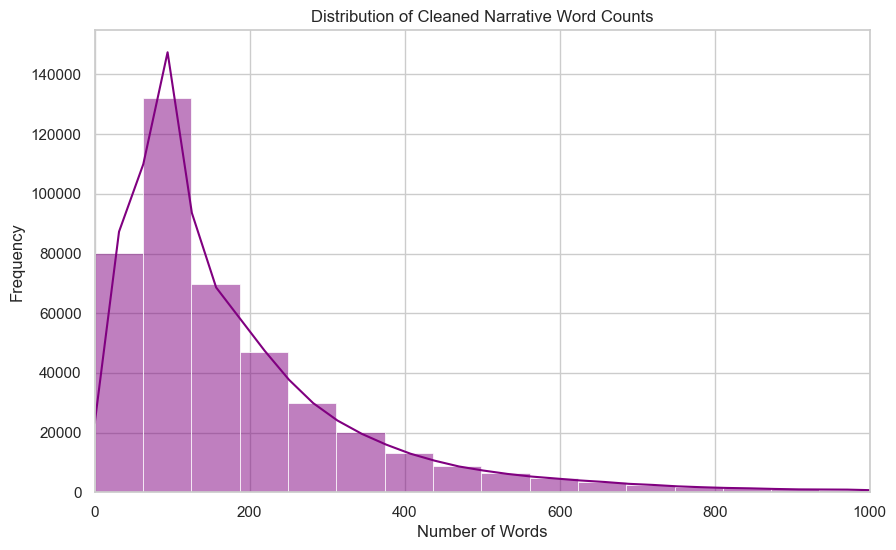

Median Word Count: 125.0
Mean Word Count: 189.76


In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['word_count'], bins=100, color='purple', kde=True)
plt.title('Distribution of Cleaned Narrative Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
# Limit x-axis to 1000 to see the bulk of the data better
plt.xlim(0, 1000)
plt.show()

print(f"Median Word Count: {df_filtered['word_count'].median()}")
print(f"Mean Word Count: {df_filtered['word_count'].mean():.2f}")

In [13]:
output_path = '../data/processed/filtered_complaints.csv'
df_filtered.to_csv(output_path, index=False)
print(f"Success! Cleaned data saved to {output_path}")

# Display a sample of the final work
df_filtered[['Product', 'cleaned_narrative', 'word_count']].head()

Success! Cleaned data saved to ../data/processed/filtered_complaints.csv


,Product,cleaned_narrative,word_count
12237,Credit card,a card was opened under my name by a fraudster...,82
12532,Checking or savings account,i made the mistake of using my wellsfargo debi...,105
13280,Credit card,i have a secured credit card with citibank whi...,152
13506,Credit card,i have a citi rewards cards the credit balance...,221
13955,Credit card,bi am writing to dispute the following charges...,443
